### 6/1 ランダムに画像を切り出し、その中にringが二つ以上入っていたならok
### ringの大きさの判定をするべき
### 一つの画像に大きいringと小さいringが入っていると小さいringが粒のようになって、変な学習をするかもしれない
### 後は、ringの選定をして、それを省いたものだけで作るのみ

In [10]:
import astropy
import astroquery.vizier
import astropy.wcs

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time
import pathlib
from PIL import Image
import aplpy
import copy

from torchvision import transforms
import torch
from torch.nn import functional as F
from torch import nn
from scipy import signal

In [14]:
l = ['spitzer_00000+0000_rgb','spitzer_02100+0000_rgb','spitzer_04200+0000_rgb','spitzer_06300+0000_rgb','spitzer_31200+0000_rgb','spitzer_33300+0000_rgb',
     'spitzer_35400+0000_rgb','spitzer_00300+0000_rgb','spitzer_02400+0000_rgb','spitzer_04500+0000_rgb','spitzer_31500+0000_rgb','spitzer_33600+0000_rgb',
     'spitzer_35700+0000_rgb','spitzer_00600+0000_rgb','spitzer_02700+0000_rgb','spitzer_04800+0000_rgb','spitzer_29700+0000_rgb','spitzer_31800+0000_rgb',
     'spitzer_33900+0000_rgb','spitzer_00900+0000_rgb','spitzer_03000+0000_rgb','spitzer_05100+0000_rgb','spitzer_30000+0000_rgb','spitzer_32100+0000_rgb',
     'spitzer_34200+0000_rgb','spitzer_01200+0000_rgb','spitzer_03300+0000_rgb','spitzer_05400+0000_rgb','spitzer_30300+0000_rgb','spitzer_32400+0000_rgb',
     'spitzer_34500+0000_rgb','spitzer_01500+0000_rgb','spitzer_03600+0000_rgb','spitzer_05700+0000_rgb','spitzer_30600+0000_rgb','spitzer_32700+0000_rgb',
     'spitzer_34800+0000_rgb','spitzer_01800+0000_rgb','spitzer_03900+0000_rgb','spitzer_06000+0000_rgb','spitzer_30900+0000_rgb','spitzer_33000+0000_rgb',
     'spitzer_35100+0000_rgb']

l = sorted(l)
#,'spitzer_29400+0000_rgb'は、8µmのデータが全然ないため、x　'spitzer_00000+0000_rgb'は、ringが無い

In [4]:
viz = astroquery.vizier.Vizier(columns=['*'])
viz.ROW_LIMIT = -1
MWP = viz.query_constraints(catalog='2019yCat..74881141J ')[0].to_pandas()
MWP.loc[MWP['GLON']>=358.446500015535, 'GLON'] -=360 
MWP

MWP    GLON    GLAT  Disp  MajAxis  MinAxis  Reff  e_Reff  \
0     2G0000794-0020817  0.0794 -0.2082  0.22     0.58     0.49  0.53    0.13   
1     2G0001255+0003035  0.1255  0.0303  1.01     5.05     4.26  4.67    0.59   
2     2G0001301-0067518  0.1301 -0.6752  0.20     0.45     0.37  0.41    0.12   
3     2G0001400-0011719  0.1400 -0.1172  0.29     3.14     2.98  3.06    0.37   
4     2G0002791-0048490  0.2791 -0.4849  0.12     0.42     0.38  0.40    0.23   
...                 ...     ...     ...   ...      ...      ...   ...     ...   
2595  2G3593514-0041492 -0.6486 -0.4149  0.34     0.44     0.35  0.40    0.24   
2596  2G3596901+0006590 -0.3099  0.0659  0.10     0.59     0.51  0.55    0.06   
2597  2G3597425-0041121 -0.2575 -0.4112  0.94     1.97     1.82  1.90    0.68   
2598  2G3599224+0011336 -0.0776  0.1134  0.28     1.08     0.93  1.00    0.31   
2599  2G3599593-0050933 -0.0407 -0.5093  0.73     2.07     1.55  1.83    0.55   

      theta  e_theta  ...   HR2   HR3  RelFlag HierFlag            IDDR1  \
0       161      133  ...  0.06  0.18        R           1G000080-002075   
1        87       62  ...   NaN  0.20        C           1G000127+000485   
2        24      122  ...  0.18  0.42        R                             
3        11       86  ...   NaN  0.46        C           1G000140-001173   
4        34       94  ...  0.18  0.08        R                             
...     ...      ...  ...   ...   ...      ...      ...              ...   
2595     52       83  ...  0.06  0.08        C           1G359350-004141   
2596     77       79  ...   NaN  0.13        C                             
2597     27      106  ...  0.32  0.44        R           1G359737-004097   
2598    103       64  ...   NaN  0.24        C                             
2599     31      131  ...  0.35  0.35        R           1G359955-005070   

                IDA14 Dist  IDCW  _RA.icrs  _DE.icrs  
0     G000.079-00.211  NaN   CN2  266.6554  -28.9766  
1     G000.132+00.039  NaN        266.4501  -28.8133  
2     G000.129-00.674  NaN   CN4  267.1427  -29.1749  
3     G000.138-00.115  NaN        266.6025  -28.8776  
4     G000.279-00.482  NaN   CN7  267.0442  -28.9491  
...               ...  ...   ...       ...       ...  
2595  G359.349-00.417  NaN        266.4237  -29.7059  
2596  G359.690+00.065  NaN        266.1557  -29.1661  
2597  G359.740-00.412  NaN   CS2  266.6538  -29.3700  
2598  G359.930+00.108  NaN        266.2482  -28.9432  
2599  G359.956-00.506  NaN   CS1  266.8789  -29.2354  

[2600 rows x 21 columns]

#### それぞれのfitsにどの程度ringが存在するのかを確認

spitzer_00000+0000_rgb
0


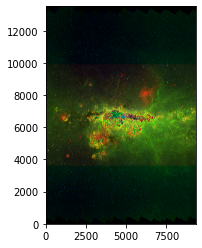

spitzer_00300+0000_rgb
50


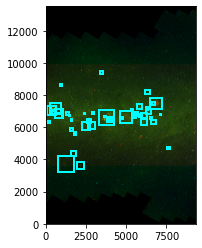

spitzer_00600+0000_rgb
62


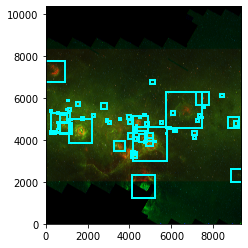

spitzer_00900+0000_rgb
67


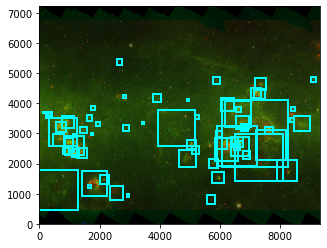

spitzer_01200+0000_rgb
88


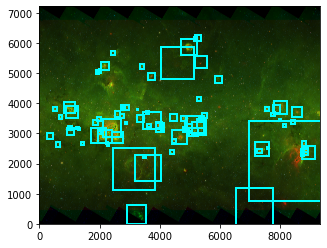

spitzer_01500+0000_rgb
58


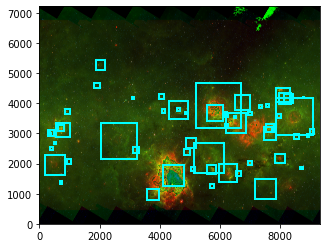

spitzer_01800+0000_rgb
79


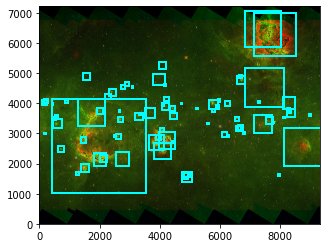

spitzer_02100+0000_rgb
57


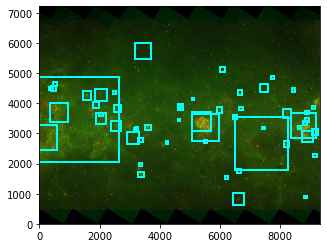

spitzer_02400+0000_rgb
104


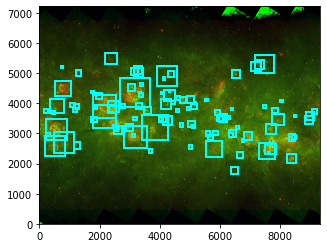

spitzer_02700+0000_rgb
67


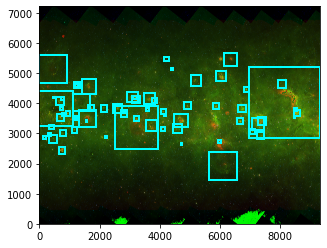

spitzer_03000+0000_rgb
107


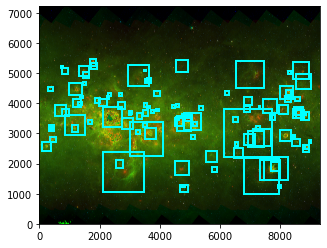

spitzer_03300+0000_rgb
78


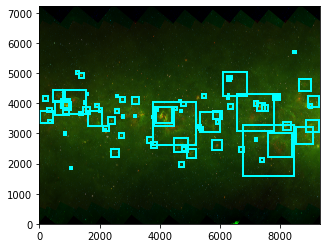

spitzer_03600+0000_rgb
51


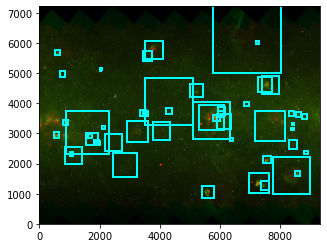

spitzer_03900+0000_rgb
57


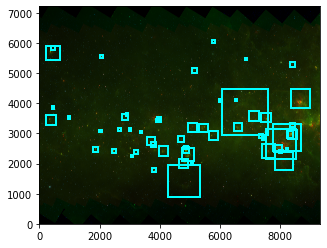

spitzer_04200+0000_rgb
46


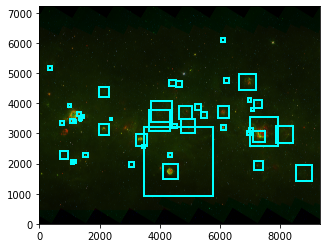

spitzer_04500+0000_rgb
60


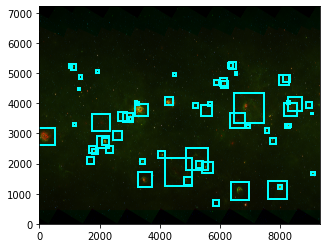

spitzer_04800+0000_rgb
45


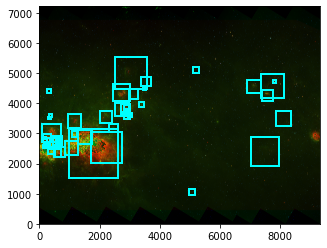

spitzer_05100+0000_rgb
59


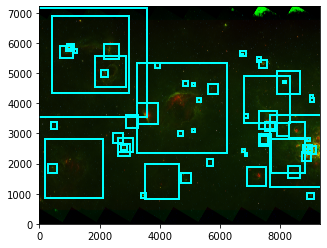

spitzer_05400+0000_rgb
36


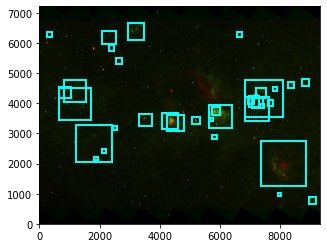

spitzer_05700+0000_rgb
22


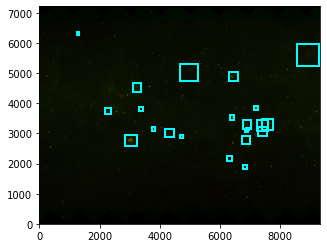

spitzer_06000+0000_rgb
24


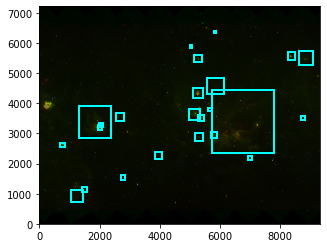

spitzer_06300+0000_rgb
15


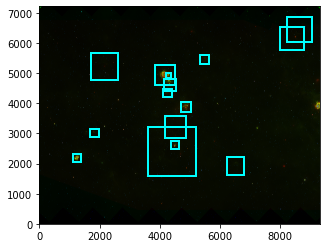

spitzer_29700+0000_rgb
23


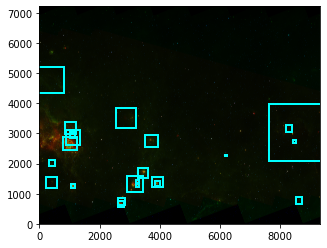

spitzer_30000+0000_rgb
30


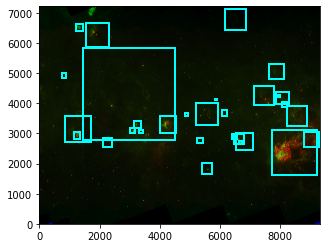

spitzer_30300+0000_rgb
51


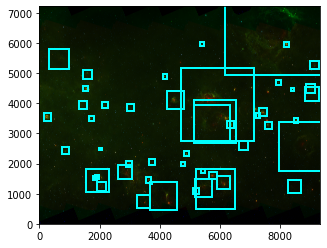

spitzer_30600+0000_rgb
56


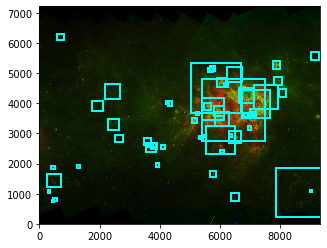

spitzer_30900+0000_rgb
38


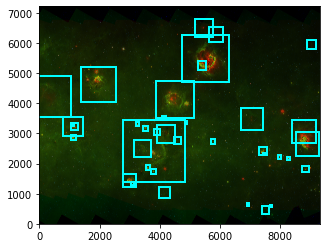

spitzer_31200+0000_rgb
73


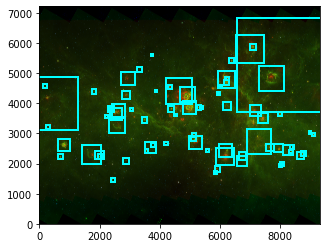

spitzer_31500+0000_rgb
38


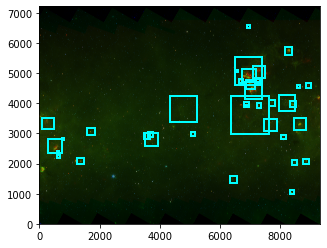

spitzer_31800+0000_rgb
41


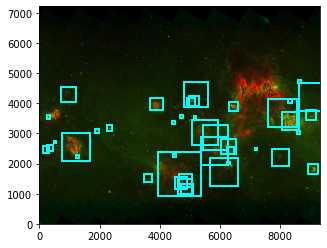

spitzer_32100+0000_rgb
64


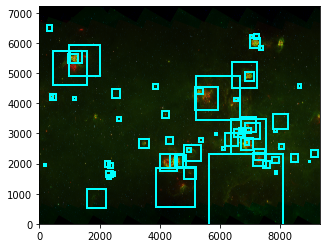

spitzer_32400+0000_rgb
32


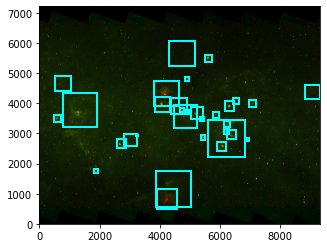

spitzer_32700+0000_rgb
75


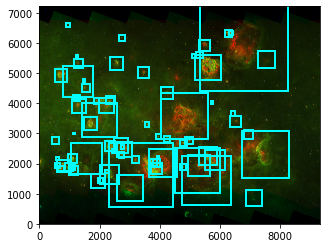

spitzer_33000+0000_rgb
74


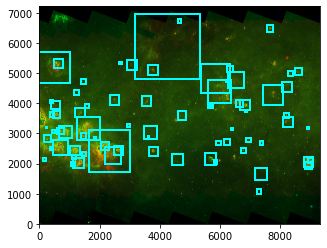

spitzer_33300+0000_rgb
103


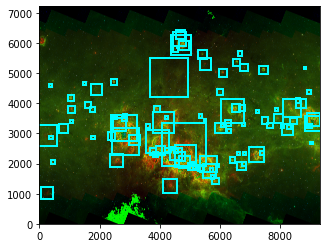

spitzer_33600+0000_rgb
79


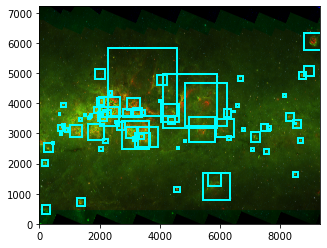

spitzer_33900+0000_rgb
89


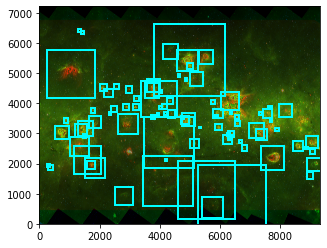

spitzer_34200+0000_rgb
65


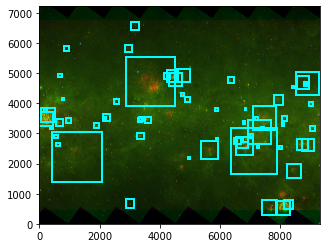

spitzer_34500+0000_rgb
65


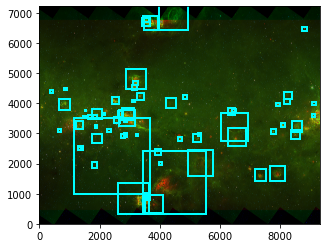

spitzer_34800+0000_rgb
58


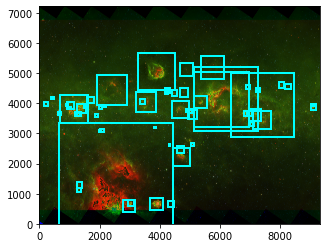

spitzer_35100+0000_rgb
79


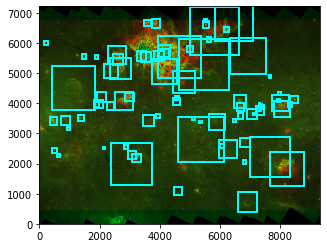

spitzer_35400+0000_rgb
53


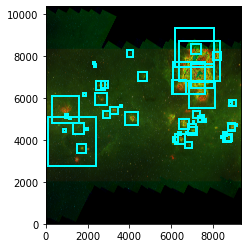

spitzer_35700+0000_rgb
54


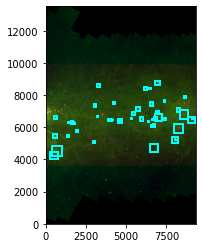

2472


In [15]:
start = time.time()

file_path = pathlib.Path('../../../fits_data/remove_saturation_nan_fits/')
count_all = 0
sig1 = 1/(2*(np.log(2))**(1/2))
for i in range(len(l)): 
    count_p = 0
    fits_path = l[i]
    spitzer_rfits = astropy.io.fits.open(file_path/fits_path/'r.fits')[0]
    spitzer_gfits = astropy.io.fits.open(file_path/fits_path/'g.fits')[0]
    spitzer_bfits = astropy.io.fits.open(file_path/fits_path/'b.fits')[0]
    w = astropy.wcs.WCS(spitzer_rfits.header)
    
    #RGBにしたいため、fitsのdataを重ねる
    data = np.concatenate([spitzer_rfits.data[:,:,None], spitzer_gfits.data[:,:,None], spitzer_bfits.data[:,:,None]], axis=2)
#     data_ =  copy.deepcopy(data)
    a = data.shape[0]
    b = data.shape[1]
    w = astropy.wcs.WCS(spitzer_rfits.header)
    GLON_min, GLAT_min = w.all_pix2world(b, 0, 0)
    GLON_max, GLAT_max = w.all_pix2world(0, a, 0) 

    GLON_center = (GLON_min+GLON_max)/2
    GLON_new_min = GLON_center-1.5
    GLON_new_max = GLON_center+1.5

    mwp = MWP.query('@GLON_new_min < GLON <= @GLON_new_max')
    print(fits_path)
#     data_ = normalize(data_)
    plt.imshow(np.uint8(data), vmin=0, vmax=255, origin='lower')
    ax = plt.gca()
    
    for index,row in mwp.iterrows():
        xmin, ymin = w.all_world2pix(row['GLON']+3*row['Reff']/60, 
                         row['GLAT']-3*row['Reff']/60, 0)
        xmax = xmin + 6*row['Reff']/(spitzer_rfits.header['PIXSCAL1']/60)
        ymax = ymin + 6*row['Reff']/(spitzer_rfits.header['PIXSCAL1']/60)
        rect = patches.Rectangle([xmin, ymin], 
                             6*row['Reff']/(spitzer_rfits.header['PIXSCAL1']/60), 
                             6*row['Reff']/(spitzer_rfits.header['PIXSCAL1']/60), 
                             linewidth=2, fill=False, edgecolor='cyan')
        count_p += 1 
        count_all += 1
        
        ax.add_patch(rect)
    
    print(count_p)
    plt.show()   
    
print(count_all)